# SRV demo-dataset and fine-tune

In this notebook we create a (demo) 9-qubit dataset and fine-tune the model with it. Note, we use direct fine-tuning similar as you would train the model from scratch (with a higher learn-rate and larger dataset).

In [ ]:
from genQC.imports import *

import genQC.util as util
import genQC.platform.qcircuit_dataset_construction as data_const
import genQC.inference.infer_srv as infer_srv
import genQC.dataset.dataset_helper as dahe

from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from genQC.dataset.qc_dataset import Qc_Config_Dataset
from genQC.dataset.mixed_cached_qc_dataset import Mixed_Cached_OpenClip_Dataset

In [ ]:
device = util.infer_torch_device()  # use cuda if we can, cpu is much slower
util.MemoryCleaner.purge_mem()      # clean existing memory alloc

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


## Setup and load

In [ ]:
def get_preTrained_pipeline():
    model_path = "../../saves/qc_unet_config_SRV_3to8_qubit/"
    pipeline   = DiffusionPipeline.from_config_file(model_path, device)  
    return pipeline

Load the pre-trained model. Set 20 sample steps and use rescaled guidance-formula.

In [ ]:
pipeline = get_preTrained_pipeline()

pipeline.guidance_sample_mode = "rescaled"
pipeline.scheduler.set_timesteps(20) 

print("Trained with gates:", pipeline.gate_pool)

[INFO]: `genQC.models.unet_qc.QC_Cond_UNet` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. No save_path` provided. No state dict loaded.
Trained with gates: [<class 'qiskit.circuit.library.standard_gates.h.HGate'>, <class 'qiskit.circuit.library.standard_gates.x.CXGate'>]


## Generate 9 qubit circuits without fine-tune

Generate circuits as explained in the `0_hello_circuit` [[doc]](https://florianfuerrutter.github.io/genQC/examples/hello_circuit.html) [[notebook]](https://github.com/FlorianFuerrutter/genQC/blob/main/src/examples/0_hello_circuit.ipynb) example.

In [ ]:
srv           = [2, 2, 2, 1, 1, 1, 1, 1, 2]  # set your target SRV
num_of_qubits = len(srv)          
assert num_of_qubits == 9

prompt = f"Generate SRV: {srv}"  # model was trained with this phrase
prompt

'Generate SRV: [2, 2, 2, 1, 1, 1, 1, 1, 2]'

In [ ]:
g         = 7.5     # guidance scale
max_gates = 16      # how many time steps the tensor encoding has
samples   = 64      # how many circuits to generate

out_tensor                   = infer_srv.generate_srv_tensors(pipeline, prompt, samples, num_of_qubits, num_of_qubits, max_gates, g, no_bar=False) 
qc_list, error_cnt, srv_list = infer_srv.convert_tensors_to_srvs(out_tensor, pipeline.gate_pool)  # may take a moment, has to compute partial traces over (2^9)x(2^9) density matrices
print(f"Not valid error circuits: {error_cnt} out of {samples}")

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_srv_tensors) Generated 64 tensors
Not valid error circuits: 1 out of 64


In [ ]:
acc = infer_srv.get_srv_accuracy(srv_list, srv)
print(f"Accuracy on requested {len(srv)} qubit SRV={srv}, with a model trained on 3 to 8 qubits circuits: {acc:.2f}")  

Accuracy on requested 9 qubit SRV=[2, 2, 2, 1, 1, 1, 1, 1, 2], with a model trained on 3 to 8 qubits circuits: 0.02


## Fine-tune dataset

Let's create a 9 qubit fine-tune training dataset.

### Sampling random circuits

We sample random 9 qubit circuits on which we fine-tune on. Note, there is no balancing over what SRVs are created! The initial model was only trained on 3 to 8 qubit circuits.

In [ ]:
# settings for random circuit sampling
random_samples = int(512)                 # how many rnd qcs we sample, here small number to speed up example
num_of_qubits  = 9
min_gates      = 2
max_gates      = 20
gate_pool      = pipeline.gate_pool  
optimized      = True                     # if qiskit optimizer is used

x, y = data_const.gen_qc_dataset(samples=random_samples, num_of_qubits=num_of_qubits, min_gates=min_gates, max_gates=max_gates, 
                                gate_pool=gate_pool, optimized=optimized, silent=False)

  0%|          | 0/512 [00:00<?, ?it/s]

Generated unique circuits: 511


In [ ]:
y[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)

In [ ]:
y = np.array([f"Generate SRV: {srv.numpy()}" for srv in y]) # convert SRV to the trained prompt
y[0]

'Generate SRV: [1 1 1 1 1 1 1 1 1]'

We get tokenized circuits with SRV:

In [ ]:
print(f"Example circuit with prompt: \n{y[-1]} \n{x[-1]}")

Example circuit with prompt: 
Generate SRV: [1 1 1 1 2 1 2 1 1] 
tensor([[ 2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-2,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, -2,  1,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  2,  1,  2, -2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, -2,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, -2,  0, -2,  0,  0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=torch.int32)


### Create a basic dataset

Direct fine-tuning is the same as you would train a new model from scratch. First, we create a `Qc_Config_Dataset` object that handles our dataset.

In [ ]:
# meta-data of dataset
paras = {}
paras["store_dict"]     = {'x':'tensor', 'y':'numpy'}   #what is in the datset, with type
paras["optimized"]      = optimized    
paras["dataset_to_gpu"] = True if device=="cuda" else False
paras["random_samples"] = random_samples
paras["num_of_qubits"]  = num_of_qubits
paras["min_gates"]      = min_gates
paras["max_gates"]      = max_gates
paras["gate_pool"]      = [dahe.class_to_str(gate) for gate in gate_pool]

Make sure our dataset has no duplicates and shuffle it:

In [ ]:
x, y = dahe.uniquify_tensor_dataset(x, y)
assert x.shape[0] == x.unique(dim=0).shape[0]    # check if no duplicates

x, y = dahe.shuffle_tensor_dataset(x, y)

Now create the `Qc_Config_Dataset` object:

Label: ``Generate SRV: [1 1 1 1 1 1 1 1 1]``    SRV is: [1, 1, 1, 1, 1, 1, 1, 1, 1]


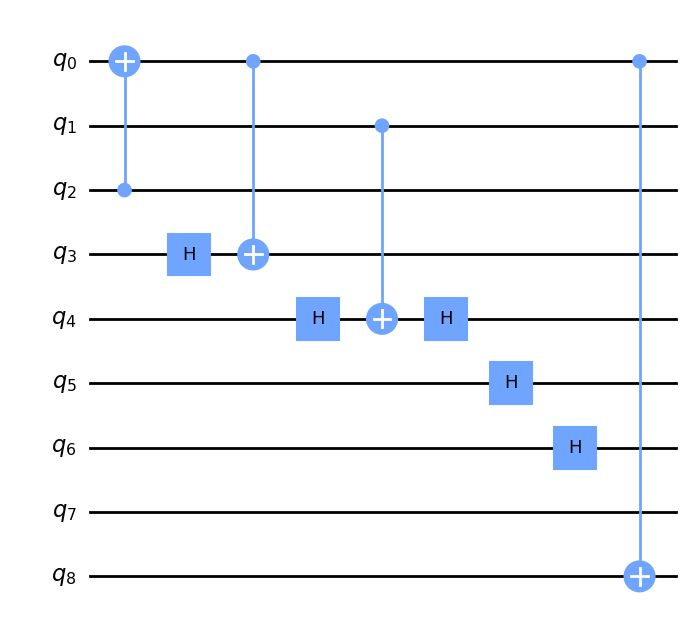

In [ ]:
qc_Config_Dataset = Qc_Config_Dataset(store_device=device, **paras)
qc_Config_Dataset.x = x
qc_Config_Dataset.y = y
qc_Config_Dataset.dataset_to_gpu = True if device.type=="cuda" else False 
qc_Config_Dataset.plot_example()

In [ ]:
# qc_Config_Dataset.plot_distribution() #print the SRV distribution percentages

If you want to save the dataset to disk, you could use:

```python
config_path = "YOUR_CONFIG_FILE"  
save_path   = "YOUR_SAVE_PATH"    
qc_Config_Dataset.save_dataset(config_path, save_path)
```
where `config_path` file-path to the meta-data file, e.g. `"../../configs/dataset/qc_9bit_fine_tune.yaml`

and `save_path` file-path prefix where the raw dataset files are stored, e.g. `"../../datasets/q-circuits/qc_9bit_fine_tune"`.

A saved dataset can be loaded with:
```python
qc_Config_Dataset = Qc_Config_Dataset.from_config_file(config_path, device=device) 
```

### Create a cached (mixed) dataset

To speed up training we can cache the CLIP embeddings of the `y` dataset labels before we start fitting. We provide the `Cached_OpenClip_Dataset` object for this. Here we use a further extension, the `Mixed_Cached_OpenClip_Dataset`. It has advanced methods to handle padding and combining different task (e.g. compile and SRV) or different number of qubit datasets together (as explained in the appendix of the paper). We use it here to automatically cut and pad our 9 qubit circuits to the longest circuit within one batch.

See if the pipeline has already a padding token specified, else define one.

In [ ]:
try:    pad_constant = pipeline.params_config("")["add_config"]["dataset"]["params"]["pad_constant"]  #can NOT be 0 (empty token)! and not any other gate!
except: pad_constant = len(qc_Config_Dataset.gate_pool)+1
    
print(f"{pad_constant=}")

pad_constant=3


In [ ]:
dataset_list = [qc_Config_Dataset]                  # what datasets to combine

parameters   = asdict(qc_Config_Dataset.params_config)
parameters["num_down_scales"] = 3                   # defined by the down-scale layers of the UNet

mixed_dataset = Mixed_Cached_OpenClip_Dataset.from_datasets(dataset_list,                 
                 balance_maxes=[1e8],          # what the maximum prompt (y) balance limit is, can be used to balance SRVs for different qubit numbers                                      
                 pad_constant=pad_constant,
                 device=device, 
                 bucket_batch_size=-1,       # if we use bucket padding
                 max_samples=[1e8],            # if we want to limit the sizes of the dataset_list 
                 **parameters)

  0%|          | 0/1 [00:00<?, ?it/s]

 - dataset size after balancing 511


Let's see what we are training on:

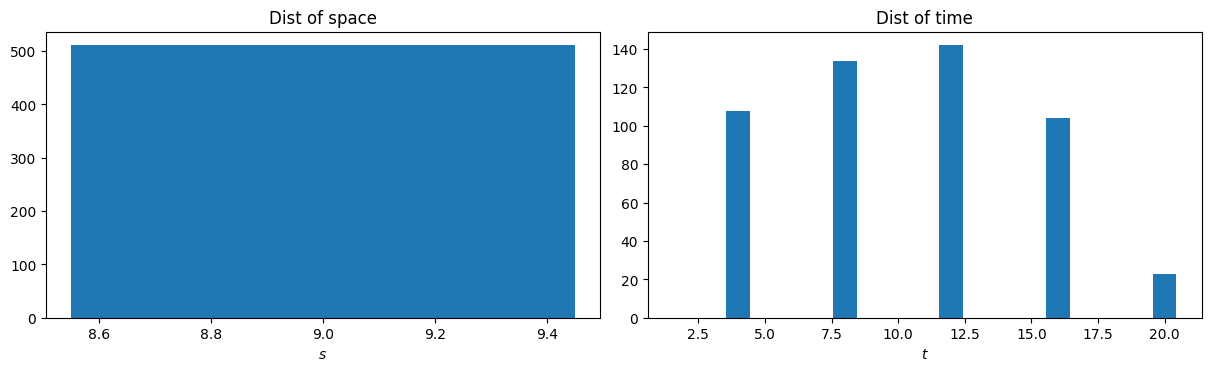

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3.6), squeeze=False, constrained_layout=True)  
plt.sca(axs[0, 0])
plt.xlabel(r"$s$")
plt.title("Dist of space")
min_q, max_q = min(d.num_of_qubits for d in dataset_list), max(d.num_of_qubits for d in dataset_list)
data = mixed_dataset.z[:, 0].cpu() 
plt.hist(data, bins=np.arange(min_q, max_q+2) - 0.5, rwidth=0.9)

plt.sca(axs[0, 1])
plt.xlabel(r"$t$")
plt.title("Dist of time")
min_g, max_g = min(d.min_gates for d in dataset_list), max(d.max_gates for d in dataset_list)
data = mixed_dataset.z[:, 1].cpu()
plt.hist(data, bins=np.arange(min_g, max_g+2) - 0.5, rwidth=0.9)

plt.show()

Finally, we can create the dataloader used by the `DiffusionPipeline.fit()` funtion. This also caches all our prompts.

In [ ]:
tuned_pipeline = get_preTrained_pipeline()  # load a fresh pre-trained model we want to train

dataloaders = mixed_dataset.get_dataloaders(batch_size=16, text_encoder=tuned_pipeline.text_encoder.to(device), y_on_cpu=False)  # you can set y_on_cpu=True if you run out of device mem

[INFO]: `genQC.models.unet_qc.QC_Cond_UNet` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. No save_path` provided. No state dict loaded.
[INFO]: Not balancing dataset!  balance_max=None
[INFO]: Generate cache: converting tensors to str and tokenize
 - to str list
 - tokenize_and_push_to_device
 - generate_cache


  0%|          | 0/1 [00:00<?, ?it/s]

[INFO]: caching trying to allocate memory (148, 77, 512) on cuda approx. 0.023 GB
[INFO]: Generated cache


## Fine-tune

We have the dataloader object created and can start fine-tuning. Note, we just use all the diffusion scheduler parameters from the pre-trained config we loaded. 

In [ ]:
tuned_pipeline.add_config["dataset"] = mixed_dataset.get_config()   # add meta-data of dataset to save it with pipeline
tuned_pipeline.compile(torch.optim.Adam, nn.MSELoss)

Fit:   0%|          | 0/25 [00:00<?, ? epoch/s]

Epoch 0:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 0:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 1:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 1:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 2:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 2:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 3:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 3:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 4:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 4:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 5:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 5:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 6:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 6:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 7:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 7:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 8:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 8:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 9:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 9:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 10:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 10:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 11:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 11:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 12:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 12:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 13:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 13:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 14:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 14:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 15:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 15:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 16:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 16:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 17:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 17:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 18:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 18:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 19:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 19:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 20:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 20:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 21:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 21:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 22:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 22:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 23:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 23:   0%|          | 0/4 [00:00<?, ? batch/s]

Epoch 24:   0%|          | 0/29 [00:00<?, ? batch/s]

Epoch 24:   0%|          | 0/4 [00:00<?, ? batch/s]

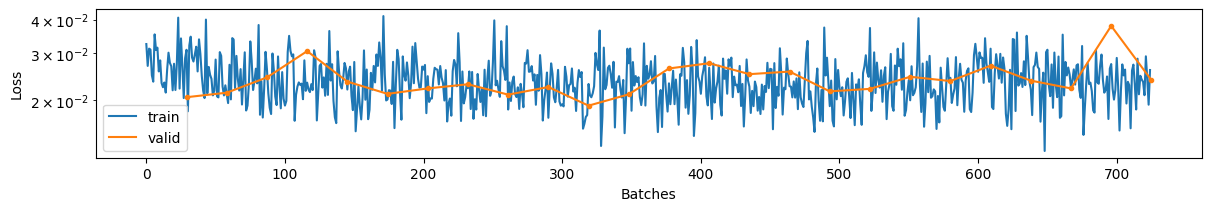

In [ ]:
epochs = 25      # how many epochs we train on our 9bit dataset
lr     = 5e-5    # learn rate

sched = functools.partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=epochs*len(dataloaders.train))
tuned_pipeline.fit(epochs, dataloaders, lr=lr, lr_sched=sched)

If you want you can save the tuned pipeline with:

```python
store_dir = f"../../saves/fine_tuned_on_9bits/"

tuned_pipeline.store_pipeline(config_path=store_dir, save_path=store_dir)
```

and load it again with the usual:

```python
tuned_pipeline = DiffusionPipeline.from_config_file(model_path, device)  
```

## Generate 9 qubit circuits fine-tuned

Test again to create a 9 qubit SRV as we did at the start but with the tuned model:

In [ ]:
prompt

'Generate SRV: [2, 2, 2, 1, 1, 1, 1, 1, 2]'

In [ ]:
g         = 7.5     # guidance scale
max_gates = 16      # how many time steps the tensor encoding has
samples   = 64      # how many circuits to generate

tuned_pipeline.guidance_sample_mode = "rescaled"
tuned_pipeline.scheduler.set_timesteps(20) 

out_tensor                   = infer_srv.generate_srv_tensors(tuned_pipeline, prompt, samples, num_of_qubits, num_of_qubits, max_gates, g, no_bar=False) 
qc_list, error_cnt, srv_list = infer_srv.convert_tensors_to_srvs(out_tensor, tuned_pipeline.gate_pool) # may take a moment, has to compute partial traces over (2^9)x(2^9) density matrices
print(f"Not valid error circuits: {error_cnt} out of {samples}")

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_srv_tensors) Generated 64 tensors
Not valid error circuits: 1 out of 64


In [ ]:
tuned_acc = infer_srv.get_srv_accuracy(srv_list, srv)
print(f"Accuracy on requested {len(srv)} qubit SRV={srv}, with a model trained on 3 to 8 qubits qcs: {acc:.2f} and with fine-tuning on 9 qubit qcs: {tuned_acc:.2f}")  

Accuracy on requested 9 qubit SRV=[2, 2, 2, 1, 1, 1, 1, 1, 2], with a model trained on 3 to 8 qubits qcs: 0.02 and with fine-tuning on 9 qubit qcs: 0.05


Note, we didn't fine-tune on a balanced dataset with all possible 9 qubit SRVs, just some random circuits (most, ~50%, of them will be the SRV with all 1s). So we don't expect a huge boost in accuracy.